<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Feature-normalization" data-toc-modified-id="Feature-normalization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Feature normalization</a></span></li><li><span><a href="#Gradient-Descent-Setup" data-toc-modified-id="Gradient-Descent-Setup-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Gradient Descent Setup</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Gradient-of-the-objective-function:" data-toc-modified-id="Gradient-of-the-objective-function:-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Gradient of the objective function:</a></span></li><li><span><a href="#first-order-approximation" data-toc-modified-id="first-order-approximation-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>first-order approximation</a></span></li><li><span><a href="#Gradient-update-step" data-toc-modified-id="Gradient-update-step-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Gradient update step</a></span></li></ul></li><li><span><a href="#The-square-loss-function" data-toc-modified-id="The-square-loss-function-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>The square loss function</a></span></li><li><span><a href="#Square-loss-gradient" data-toc-modified-id="Square-loss-gradient-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Square loss gradient</a></span></li><li><span><a href="#Gradient-checker" data-toc-modified-id="Gradient-checker-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Gradient checker</a></span></li><li><span><a href="#Generic-Gradient-Checker" data-toc-modified-id="Generic-Gradient-Checker-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Generic Gradient Checker</a></span></li><li><span><a href="#Batch-Gradient-Descent" data-toc-modified-id="Batch-Gradient-Descent-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Batch Gradient Descent</a></span><ul class="toc-item"><li><span><a href="#Step-size" data-toc-modified-id="Step-size-2.7.1"><span class="toc-item-num">2.7.1&nbsp;&nbsp;</span>Step size</a></span></li><li><span><a href="#Backtracking-line-search" data-toc-modified-id="Backtracking-line-search-2.7.2"><span class="toc-item-num">2.7.2&nbsp;&nbsp;</span>Backtracking line search</a></span></li><li><span><a href="#Learning-rate" data-toc-modified-id="Learning-rate-2.7.3"><span class="toc-item-num">2.7.3&nbsp;&nbsp;</span>Learning rate</a></span></li></ul></li></ul></li><li><span><a href="#Ridge-regression-(i.e.-Linear-Regression-with-$l_2$-regularization)" data-toc-modified-id="Ridge-regression-(i.e.-Linear-Regression-with-$l_2$-regularization)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ridge regression (i.e. Linear Regression with $l_2$ regularization)</a></span></li><li><span><a href="#Stochastic-Gradient-Descent" data-toc-modified-id="Stochastic-Gradient-Descent-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stochastic Gradient Descent</a></span></li></ul></div>

# Ridge Regression, Gradient Descent, SGD

Assignment for the [Foundations of Machine Learning](https://bloomberg.github.io/foml/#about) course.

In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Introduction

This notebook implements ridge regression using gradient descent and stochastic gradient descent.

## Linear Regression

### Feature normalization

Why?
- When features differ greatly, we can get much slower rates of convergence of gradient-based algorithms. 
- When we using regularization, features with larger values are treated as 'more important' (get higher weights) 

One common approach to feature normalization is to perform an affine transformation (i.e. shift and rescale) on each feature so that all feature values in the training set are in \[0,1\]. Each feature gets its own transformation. We then apply the same transformations to each feature on the test set.  

In [2]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """
    #Test if the feature is constant
    mask = np.all(train == train[0,:], axis = 0) #compares all lines to the first line and returns a boolean array 
    mask = [not x for x in mask]
    mask = np.asarray(mask)
    
    #discard constant features
    train = train[:,mask]
    test = test[:,mask]
    
    #Normalize train and test sets between [0,1]
    train_normalized = (train - train.min(axis=0))/(train.max(axis=0)-train.min(axis=0))
    test_normalized = (test - train.min(axis=0))/(train.max(axis=0)-train.min(axis=0))
    return (train_normalized, test_normalized)

### Gradient Descent Setup

In linear regression, we consider the hypothesis space of linear functions $h_\theta : R^d \to R$, where  
  
$$h_\theta(x) = \theta^Tx,$$  
  
for $\theta, x \in R^d$, and we choose  $\theta$ that minimizes the following “square loss” objective function:  

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^n (h_\theta(x_i)−y_i)^2,$$  

where $(x_1, y_1), ..., (x_m, y_m) \in R^d \times R$ is our training data.  
While this formulation of linear regression is very convenient, it’s more standard to use a hypothesis space of “affine” functions:
$$h_\theta(x) = \theta^Tx + b,$$  

which allows a “bias” or nonzero intercept term. The standard way to achieve this, while still maintaining the convenience of the first representation, is to add an extra dimension to $x$ that is always a fixed value, such as 1.  
We’ll assume this representation, and thus we’ll actually take  $\theta, x \in R^{d+1}$.

#### Objective function
$X \in R^{m\times(d+1)}$ is the design matrix, where the *i*’th row of $X$ is $x_i$.  
$y = (y_1, ...,y_m)^T \in R^{m\times1}$ is the “response”.  
The objective function is:

$$J(\theta) = \frac{1}{m} (X\theta - y)^T(X\theta-y)$$

#### Gradient of the objective function:

Using the chain rule: if $ h(x) = f(g(x)) $, then $ h'(x) = f'(g(x))\cdot g'(x) $  

$$ \nabla J(\theta) = \frac{2}{m}X^T(X\theta - y) $$

#### first-order approximation

We can write an approximate expression for the change in objective function value $J(\theta + \eta h) - J(\theta)$

We have: $$ \nabla J(\theta, h) = \lim\limits_{\eta \to 0} \frac {J(\theta + \eta h)- J(\theta)}{\eta}$$
  
Therefore:
$J(\theta + \eta h) - J(\theta) \approx \eta \nabla J(\theta,h) $

#### Gradient update step 
Let $\eta$ be the step size. The expression for updating $\theta$ in the gradient descent algorithm is:

$\theta = \theta - \eta \nabla J(\theta) $
  
We 'take a step' (change $\theta$) in the direction of fastest decrease of the objective function $J(\theta)$

### The square loss function

In [3]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)

    Returns:
        loss - the square loss, scalar
    """
    loss = 0 #initialize the square_loss
    
    m = y.shape[0]
    loss = (1/(m))*np.transpose((X@theta - y))@(X@theta - y)
    
    return loss

### Square loss gradient

In [4]:
### compute the gradient of square loss function
def compute_square_loss_gradient(X, y, theta):
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    m = len(y)
    grad = (2/m)*np.transpose(X)@(X@theta - y)
    
    return grad

### Gradient checker

Getting the gradient calculation correct is often the trickiest part of any gradient-based optimization algorithm.  Fortunately, it's very easy to check that the gradient calculation is correct using the definition of gradient.
See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization

If $J: R^d \to R$ is differentiable, then for any vector $h \in R^d$, the directional derivative of $J$ at $\theta$ in the direction $h$ is given by: 
$$ \lim\limits_{\varepsilon \to 0} \frac {J(\theta + \varepsilon h)- J(\theta - \varepsilon h)}{2\varepsilon}.$$

We can approximate this directional derivative by choosing a small value of $\varepsilon > 0$ and evaluating the quotient above. We can get an approximation to the gradient by approximating the directional derivatives in each coordinate direction and putting them together into a vector. In other words, take $h = (1, 0, 0,... ,0)$ to get the first component of the gradient. Then take $h = (0, 1, 0,... ,0)$ to get the second component. And so on.

The function grad_checker checks that the function compute_square_loss returns the correct gradient.  
Note: Running the gradient checker takes extra time. In practice, once you’re convinced your gradient calculator is correct, you should stop calling the checker so things run faster.

In [5]:
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1)

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    for i in range(num_features):
        #direction vector for directional derivative:
        h = np.zeros(num_features)
        h[i] = 1
        
        #calculate the approximated gradient
        approx_grad[i] = (compute_square_loss(X, y, theta + epsilon*h) - compute_square_loss(X, y, theta - epsilon*h)) / (2*epsilon)
    
    
    dist = np.linalg.norm(true_gradient-approx_grad)
    
    return (dist < epsilon)

### Generic Gradient Checker

The function generic_grad_checker checks that any objective function returns the correct gradient.

In [6]:
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And checks whether gradient_func(X, y, theta) 
    returned the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    for i in range(num_features):
        
        #direction vector for directional derivative:
        h = np.zeros(num_features)
        h[i] = 1
        
        #calculate the approximated gradient
        approx_grad[i] = (objective_func(X, y, theta + epsilon*h) - objective_func(X, y, theta - epsilon*h)) / (2*epsilon)
    
    
    dist = np.linalg.norm(true_gradient-approx_grad)
    
    return (dist < epsilon)

### Batch Gradient Descent

Implementation of batch gradient descent to minimize the square loss objective:

In [7]:
def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False, step_size_search=False):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_iter - number of iterations to run
        check_gradient - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - store the the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features)
                    for instance, theta in iteration 0 should be theta_hist[0], theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.zeros(num_features) #initialize theta
    
    #TODO
    for i in range(num_iter):
        theta_hist[i] = theta
        loss_hist[i] = compute_square_loss(X, y, theta)
        grad = compute_square_loss_gradient(X, y, theta)
        
        if check_gradient:
            if not grad_checker(X,y,theta):
                sys.exit('Wrong gradient')
        
        if step_size_search:
            alpha = backtrack_step_search(X, y, theta, compute_square_loss, 
                                          compute_square_loss_gradient, epsilon = 1e-6)
                
            theta = theta - alpha*grad
        
        else:
            #Update theta
            theta = theta - alpha*grad
        
    theta_hist[i+1] = theta
    loss_hist[i+1] = compute_square_loss(X, y, theta)
    
    return theta_hist, loss_hist

#### Step size

Here we look at how the step size value influences the convergence of the algorithm. 

In [8]:
#Load and visualize he dataset
data = pd.read_csv('/Users/Coline/Desktop/mlprojects/Bloomberg_foundations_of_ML/hw1-sgd/data.csv')
data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x39,x40,x41,x42,x43,x44,x45,x46,x47,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.951051,-0.951051,-4.755257,-0.866019,-0.866019,-4.330093,-0.781824,-0.781824,-3.909121,-1.376575
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.948871,-0.948871,-4.744353,-0.863095,-0.863095,-4.315474,-0.778705,-0.778705,-3.893525,0.878782
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.948056,-0.948056,-4.740279,-0.862011,-0.862011,-4.310053,-0.777551,-0.777551,-3.887757,1.108701
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.941999,-0.941999,-4.709996,-0.854081,-0.854081,-4.270406,-0.769161,-0.769161,-3.845805,0.519229
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.939440,-0.939440,-4.697202,-0.850794,-0.850794,-4.253972,-0.765706,-0.765706,-3.828531,0.772872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.036417,-0.036417,-0.182083,-0.030349,-0.030349,-0.151746,-0.026015,-0.026015,-0.130073,2.503566
196,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.036086,-0.036086,-0.180430,-0.030074,-0.030074,-0.150368,-0.025778,-0.025778,-0.128892,2.414250
197,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.007125,-0.007125,-0.035624,-0.005937,-0.005937,-0.029687,-0.005089,-0.005089,-0.025446,3.379356
198,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.004506,-0.004506,-0.022530,-0.003755,-0.003755,-0.018775,-0.003219,-0.003219,-0.016093,2.468850


In [9]:
################################################
### Visualization that compares the convergence speed of batch
###and stochastic gradient descent for various approaches to step_size
##X-axis: Step number (for gradient descent) or Epoch (for SGD)
##Y-axis: log(objective_function_value) and/or objective_function_value

#Loading the dataset
print('loading the dataset')

df = pd.read_csv('/Users/Coline/Desktop/mlprojects/Bloomberg_foundations_of_ML/hw1-sgd/data.csv', delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

print('Split into Train and Test')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

print("Scaling all to [0, 1]")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


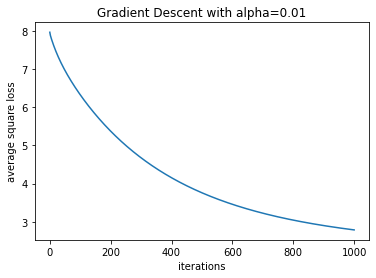

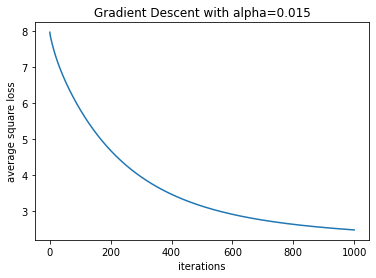

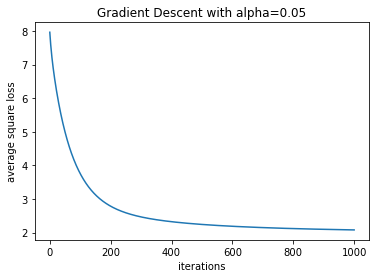

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in matmul
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in matmul
  app.launch_new_instance()


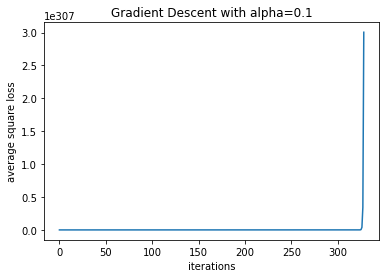

In [10]:
#Test different step sizes and plot average square loss vs iteration

for alpha in [1.0e-2, 1.5e-2, 5.0e-2, 1.0e-1]:
        theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=alpha, num_iter=1000, check_gradient=False)
        
        plt.xlabel('iterations')
        plt.ylabel('average square loss')
        plt.title('Gradient Descent with alpha=%s' % str(alpha))
        plt.plot([i for i in range(1001)], loss_hist)
        plt.show()

When the step size increases, the algorithm converges faster. For step size of 0.1, gradient descent does not converge.

#### Backtracking line search

It is a line search method to determine the amount to move along a given search direction. It involves starting with a relatively large estimate of the step size for movement along the search direction, and iteratively shrinking the step size (i.e., "backtracking") until a decrease of the objective function is observed that adequately corresponds to the decrease that is expected, based on the local gradient of the objective function. [(source)](https://en.wikipedia.org/wiki/Backtracking_line_search#Algorithm)

In [11]:
def backtrack_step_search(X, y, theta, loss_func, grad_func, epsilon = 1e-6):
    alpha = 1.0
    beta = 0.5
    loss = loss_func(X,y,theta)
    grad = grad_func(X,y,theta)
    
    while True:
        theta_next = theta - alpha*grad_func(X,y,theta)
        loss_next = loss_func(X,y,theta_next)
        if loss_next > loss-epsilon:
            alpha = alpha*beta
        else:
            return alpha

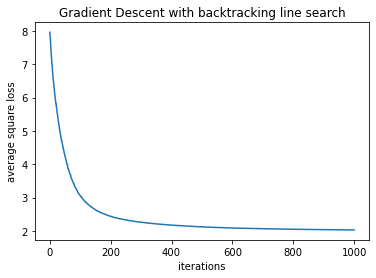

In [12]:
theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=0.01, num_iter=1000, 
                                                   check_gradient=False, step_size_search=True)
        
plt.xlabel('iterations')
plt.ylabel('average square loss')
plt.title('Gradient Descent with backtracking line search')
plt.plot([i for i in range(1001)], loss_hist)
plt.show()

Backtracking line search converges faster

#### Learning rate 
Instead of using a fixed learning rate through all iterations, we can adjust our learning rate in each iteration using a simple algo:  
Letting the algorithm to adjust the learning rate during each iteration using Armijo's rule [(source)](https://github.com/nyu-ds1003/mlcourse/blob/master/labs/02-20210210-gd%26sgd/02-20210210-gd%26sgd.pdf)

In [13]:
def gradient_descent_armijo(X,y, theta_0, lr=1e-3, n_iteration=1000):
    """
    Simple gradient descent optimization with learning rate adjusted using Armijo's rule
    @param theta_0: initial estimate
    @param lr: learning rate
    @param n_iteration: number of iterations
    """
    # create history dictionary for tracking progress per iteration.
    hist = {'lr':[], 'theta': [], 'f_theta': []}
    
    # initialize theta_0
    theta_i =  theta_0
    
    # loop over iterations
    for i in range(n_iteration):
        # calculate the gradient
        grad = compute_square_loss_gradient(X,y,theta_i)
        loss = compute_square_loss(X,y, theta_i)
        
        # calculate the next theta with this gradient
        theta_i_plus_1 = theta_i - lr * grad
        loss_i_plus_1 = compute_square_loss(X,y, theta_i_plus_1)
        
        # calculate the required improvement
        if isinstance(grad, np.ndarray):
            df_est = lr*grad.dot(grad)
        else:
            df_est = lr*grad*grad
        
        # if the improvement is significant, perform the update and increase learning rate
        if (loss_i_plus_1 < loss - 0.5*df_est):
            lr *= 2
            accept = True
        # if the improvement is insignificant, don't do the update and decrease learning rate
        else:
            lr /= 2 
            accept = False
        
        if accept:
            # do update
            theta_i = theta_i - lr * grad
            # save history
            hist['theta'].append(theta_i)
            hist['f_theta'].append(loss)
            hist['lr'].append(lr)
    return theta_i, hist

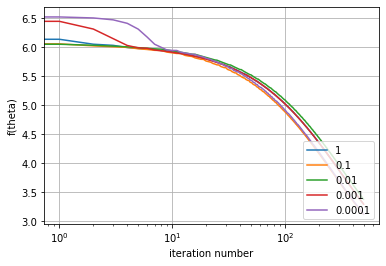

In [14]:
lr_list = [1, 0.1, 0.01, 0.001, 0.0001]
theta_init = np.zeros(X.shape[1])

for lr in lr_list:
    # run the optimizer
    theta_star, hist = gradient_descent_armijo(X,y, theta_init, lr)   
    # plot the learning curve
    plt.semilogx(np.arange(len(hist['f_theta'])), hist['f_theta'], label=str(lr))
    plt.xlabel("iteration number")
    plt.ylabel("f(theta)")
    # report 
    #print("lr = {0}, theta* = {1}, f(theta*) = {2}".format(lr, hist["theta"][-1], hist["f_theta"][-1]))
    
plt.grid()
plt.legend(loc='lower right')
plt.show()

## Ridge regression (i.e. Linear Regression with $l_2$ regularization)

When we have a large number of features compared to instances, regularization can help control overfitting.  
Ridge regression is linear regression with $l_2$ regularization. The regularization term is sometimes called a penalty term.  
The objective function (loss function) for ridge regression is: $$ J(\theta) = \frac{1}{m} \sum_{i=1}^n (h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta,$$ where $\lambda$ is the regularization parameter, which controls the degree of regularization.  

Gradient of J(θ):

$$ J(\theta) = \frac{1}{m}(\theta X − y)^T(\theta X − y) + \lambda\theta^T\theta$$
$$ \nabla J(\theta) = \frac{2}{m}X^T(\theta X − y) + 2\lambda\theta$$

In [15]:
###################################################
### Compute the gradient of Regularized Batch Gradient Descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    #TODO
    loss = 0 #initialize the square_loss
    
    m = y.shape[0]
    #grad = (2/m)*np.transpose(X)@(X@theta - y) + 2*lambda_reg*theta
    grad = (1/m)*np.dot((np.dot(X,theta.T)-y), X) + 2*lambda_reg*theta
    return grad

In [16]:
###################################################
### Batch Gradient Descent with regularization term
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_iter - number of iterations to run

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features)
        loss_hist - the history of loss function without the regularization term, 1D numpy array.
    """
    (num_instances, num_features) = X.shape
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #Initialize loss_hist
    #TODO
    
    for i in range(num_iter):
        loss_hist[i] = compute_square_loss(X, y, theta)
        theta_hist[i, :] = theta[:]
        
        theta = theta - (alpha)*compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
        
    theta_hist[i+1, :] = theta[:]
    loss_hist[i+1] = compute_square_loss(X, y, theta) + np.sum(theta**2)*lambda_reg/(2*num_instances)
    
    return theta_hist, loss_hist

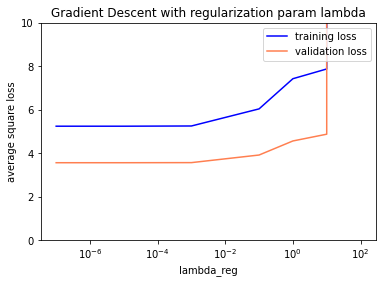

In [17]:
avg_loss_train=[]
avg_loss_test=[]
for lambda_reg in [1.0e-7, 1e-5, 1.0e-3, 1.0e-1, 1, 10, 100]:
        theta_hist_train, loss_hist_train = regularized_grad_descent(X_train, y_train, alpha=0.01, lambda_reg=lambda_reg, num_iter=1000)
        theta_hist_test, loss_hist_test = regularized_grad_descent(X_test, y_test, alpha=0.01, lambda_reg=lambda_reg, num_iter=1000)
        avg_loss_train.append(np.mean(loss_hist_train))
        avg_loss_test.append(np.mean(loss_hist_test))
        

lambda_reg = [1.0e-7, 1e-5, 1.0e-3, 1.0e-1, 1, 10, 100]
        
plt.xlabel('lambda_reg')
plt.ylabel('average square loss')
plt.title('Gradient Descent with regularization param lambda')
plt.semilogx(lambda_reg, avg_loss_train, c = 'blue', label = 'training loss')
plt.semilogx(lambda_reg, avg_loss_test, c = 'coral', label='validation loss')
plt.ylim(0,10)
plt.legend()
plt.show()

## Stochastic Gradient Descent

When the training data set is very large, evaluating the gradient of the objective function can take a long time, since it requires looking at each training example to take a single gradient step. When the objective function takes the form of an average of many values, such as: $$ J(\theta) = \frac{1}{m} \sum_{i=1}^m f_i(\theta) $$ (as it does in the empirical risk), stochastic gradient descent (SGD) can be very effective.  
In SGD, rather than taking $-\nabla J(\theta)$ as our step direction, we take $-\nabla f_i(\theta)$ for some $i$ chosen uniformly at random {_1,...,m_}. The approximation is poor, but we will show it is unbiased.  
  
In ML applications, each $ f_i(\theta)$ would be the loss on the *i*th example (and of course we'd typically write *n* instead of *m*, for the number of training points). In practical implementations for ML, the data points are **randomly shuffled**, and then we sweep through the whole training set one by one, and perform an update for each training example individually. One pass through the data is called an **epoch**. Note that each epoch of SGD touches as much data as a single step of batch gradient descent. You can use the same ordering for each epoch, tough optionally you could investigate wether reshuffling after each epoch affects the convergence speed.

1. Show that the objective function $$ J(\theta) = \frac{1}{m} \sum_{i=1}^m (h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta,$$ can be written in the form $ J(\theta) = \frac{1}{m} \sum_{i=1}^m f_i(\theta) $ by giving an expression for $f_i(\theta)$ that makes the two expressions equivalent.

We can write:
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m [(h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta]$$  
since when we sum up $\lambda\theta^T\theta$ we obtain $m\lambda\theta^T\theta$, which is equal to $\lambda\theta^T\theta$ when multiplied by $\frac{1}{m}$  
Therefore $f_i(\theta) = (h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta$

2. Show that the stochastic gradient $\nabla f_i(\theta)$ for some $i$ chosen uniformly at random from {_1,...,m_}, is an **unbiased estimator** of $\nabla J(\theta)$. In other words, show that $\mathop{\mathbb{E}}[\nabla f_i(\theta)]= \nabla J(\theta)$ for any $\theta$.

$\mathop{\mathbb{E}}[\nabla f_i(\theta)]= \nabla \mathop{\mathbb{E}} f_i(\theta)$  

$= \nabla (\sum_{j=1}^N P(i=j)f_j(\theta))  $ (definition of expectation of a function) 

$= \nabla (\frac{1}{N} \sum_{j=1}^N f_j(\theta))  $  

$= \nabla J(\theta) $
  
This means that if we use the Stochastic Gradient repeatedly, over time it will give us the same results as using the full Batch Gradient we have been using! 

3. Write down the update rule for $\theta$ in SGD for the ridge regression objective function

$\theta = \theta - \nabla f_i(\theta)$

$ \nabla f_i(\theta) = \nabla [(h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta]$  
  
Chain rule:
  
$ = 2h_\theta(x_i) - y_i)\nabla h_\theta(x_i) + 2\lambda\theta$
  
We have: 
  
$ \nabla h_\theta(x_i) = \nabla \theta^T x_i = x_i $
  
$ \nabla f_i(\theta) = 2(h_\theta(x_i) - y_i)x_i + 2\lambda\theta$
  
$ = 2[(h_\theta(x_i) - y_i)x_i + \lambda\theta] $

Stochastic Gradient Descent implementation:

In [45]:
#############################################
### Stochastic Gradient Descent
def stochastic_grad_descent(X, y, alpha=0.1, lambda_reg=0.01, num_iter=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every iteration is alpha.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t)
                if alpha == "1/t", alpha = 1/t
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features)
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta


    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    
    #TODO
    
    #Set step_size:
    if isinstance(alpha, float):
        step_size = alpha
    else:
        step_size = 1000
    
    for j in range(num_iter):
        
        # Reshuffle indices to for new epoch, so we get new random points at each iteration
        shuffled_indices = np.random.permutation(num_instances)
        
        for i in shuffled_indices:
        
            loss_SGD = compute_square_loss(X,y,theta) + lambda_reg*np.transpose(theta)@theta
            loss_hist[j,i] = loss_SGD
            grad_SGD = 2*((X[i,:]@theta - y[i])*X[i] + lambda_reg*theta)
            
            if isinstance(alpha, str):
                if alpha == "1/sqrt(t)":
                    theta = theta - (1/np.sqrt(step_size))*grad_SGD
                    theta_hist[j,i,:] = theta
                    step_size += 1
                
                if alpha == "1/t":
                    theta = theta - (1/step_size)*grad_SGD
                    theta_hist[j,i,:] = theta
                    step_size += 1
            else:
            
                theta = theta - alpha*grad_SGD
                theta_hist[j,i,:] = theta
                
                
    
    return theta_hist, loss_hist

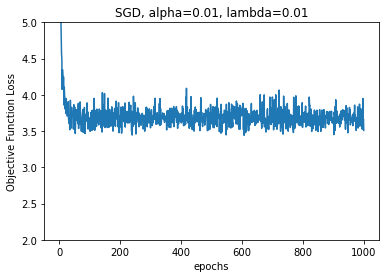

Final Training Loss: 3.5085044706644255 



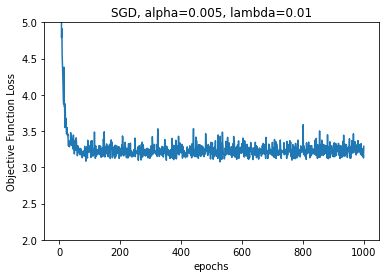

Final Training Loss: 3.289283163301497 



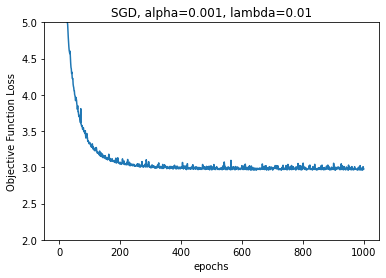

Final Training Loss: 2.9773395963336178 



In [32]:
# Run SGD with different learning rates
lamb = 0.01 # we are using optimal regularization parameter found from last
    
# try a few fixed step sizes
alphas = [0.01, 0.005, 0.001]
for alpha in alphas:
    loss_hist_train = stochastic_grad_descent(X_train, y_train, alpha=alpha, lambda_reg=lamb)[1]       
    plt.xlabel('epochs')
    plt.ylabel('Objective Function Loss')
    plt.ylim(bottom=2, top=5)
    plt.title('SGD, alpha=%s, lambda=%s' % (str(alpha), str(lamb)))
    plt.plot([i for i in range(1, 1000+1)], loss_hist_train.mean(axis=1))
    plt.show()
    print("Final Training Loss: %s \n" % (str(loss_hist_train.mean(axis=1)[-1])))

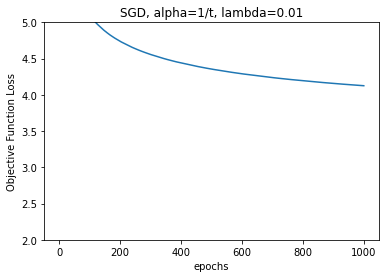

Final Training Loss: 4.125751955042337 



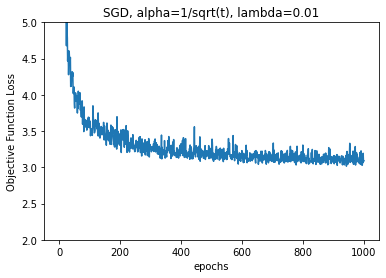

Final Training Loss: 3.092358003893253 



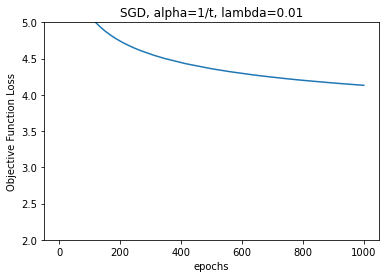

Final Training Loss: 4.131653920943756 



In [46]:
# Run SGD with different learning rates
lamb = 0.01 # we are using optimal regularization parameter found from last
    
# try step sizes that decrease with increasing number of epochs:
alphas = ['1/t', '1/sqrt(t)', '1/t']
for alpha in alphas:
    loss_hist_train = stochastic_grad_descent(X_train, y_train, alpha=alpha, lambda_reg=lamb)[1]       
    plt.xlabel('epochs')
    plt.ylabel('Objective Function Loss')
    plt.ylim(bottom=2, top=5)
    plt.title('SGD, alpha=%s, lambda=%s' % (str(alpha), str(lamb)))
    plt.plot([i for i in range(1, 1000+1)], loss_hist_train.mean(axis=1))
    plt.show()
    print("Final Training Loss: %s \n" % (str(loss_hist_train.mean(axis=1)[-1])))